## Imports and Mount Drive

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import expon as sp_expon
from scipy.stats import randint as sp_randint

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load csv into df
wine_df = pd.read_csv('/content/drive/Shareddrives/CIS_5190_Final_Project/Data/winemag-data-130k-v2.csv', index_col=0)

## Data Cleaning
___

In [ ]:
PREPEND_TO_DESCRIPTION = True

# Drop rows missing important geographic information and irrelevant columns
wine_df_clean = wine_df.dropna(subset=['province', 'country', 'variety'])  # drop rows missing important geographic data
wine_df_clean = wine_df_clean.drop(columns=['region_2', 'designation', 'taster_name', 'taster_twitter_handle'])  # drop region_2 (mostly nans) and designation (inherrently encodes georgraphic data)
wine_df_clean['region_1'] = wine_df_clean['region_1'].fillna(wine_df_clean['province'])  # impute region_1 with province if missing
wine_df_clean = wine_df_clean.drop_duplicates('description')  # drop duplicate descriptions

# Remove varieties with less than 100 instances
MIN_VARIETY_INSTANCES = 100
prev_instances = wine_df_clean.shape[0]
wine_df_clean = wine_df_clean.groupby('variety').filter((lambda d : len(d) > MIN_VARIETY_INSTANCES))
print(f'Instances lost after variety filtering: {prev_instances - wine_df_clean.shape[0]}')
if PREPEND_TO_DESCRIPTION:
  wine_df_clean['variety'] = wine_df_clean['variety'].apply(lambda d : '_'.join(d.split(' '))) # convert variety to single word
else:
  varieties = pd.get_dummies(wine_df_clean['variety'])  # one hot encode
  wine_df_clean = wine_df_clean.join(varieties)

# Remove regions, countries provinces with less than 100 instances
MIN_REGION_INSTANCES = 100
cols = ['country', 'province', 'region_1']
for col in cols:
  prev_instances = wine_df_clean.shape[0]
  wine_df_clean = wine_df_clean.groupby(col).filter((lambda d : len(d) > MIN_REGION_INSTANCES))
  print(f'Instances lost after {col} filtering: {prev_instances - wine_df_clean.shape[0]}')
print('-------------------------------------')
print(f'Total Remaining Instances: {wine_df_clean.shape[0]}')

# Normalize numeric fields
normalize = lambda df, col: (df[col] - df[col].min()) / (df[col].max() - df[col].min())
wine_df_clean['price'] = normalize(wine_df, 'price')
wine_df_clean['points'] = normalize(wine_df, 'points')


# add indicator column for missing price, then fill with mean
if not PREPEND_TO_DESCRIPTION:
  wine_df_clean['no_price'] = wine_df_clean.apply(lambda x : 1 if np.isnan(x['price']) else 0, axis=1)  # 1 hot encodings for missing price
  wine_df_clean['price'] = wine_df_clean['price'].fillna(wine_df_clean['price'].mean())

Instances lost after variety filtering: 7493
Instances lost after country filtering: 681
Instances lost after province filtering: 3726
Instances lost after region_1 filtering: 16383
-------------------------------------
Total Remaining Instances: 91612


### Encoding Numeric and Categorical Features into Text

In [ ]:
if PREPEND_TO_DESCRIPTION:
  # Convert price and points to categorical
  price_desc = wine_df_clean['price'].describe()
  points_desc = wine_df_clean['points'].describe()

  # Price and Points as Categorical
  def categorical_mapper(d, desc, mapper):
    if np.isnan(d):
      return mapper['nan']
    elif d < desc['25%']:
      return mapper['l']
    elif d < desc['75%']:
      return mapper['m']
    else:
      return mapper['h']

  wine_df_clean['price_categorical'] = wine_df_clean['price'].apply( \
      lambda d : categorical_mapper(d, price_desc, {'nan': 'no_price', 'l': 'affordable', 'm': 'standard', 'h': 'expensive'}))
  wine_df_clean['points_categorical'] = wine_df_clean['points'].apply( \
      lambda d : categorical_mapper(d, points_desc, {'nan': 'no_points', 'l': 'low_points', 'm': 'medium_points', 'h': 'high_points'}))

In [ ]:
if PREPEND_TO_DESCRIPTION:
  # Prepending Categorical
  CATEGORICAL = ['price_categorical', 'points_categorical', 'variety']
  for col in CATEGORICAL:
    wine_df_clean['description'] = wine_df_clean.apply(lambda d : d[col] + ' ' + d['description'], axis=1)
  print(wine_df_clean['description'].head(10))

0     White_Blend medium_points no_price Aromas incl...
1     Portuguese_Red medium_points affordable This i...
2     Pinot_Gris medium_points affordable Tart and s...
4     Pinot_Noir medium_points expensive Much like t...
7     Gewürztraminer medium_points standard This dry...
8     Gewürztraminer medium_points affordable Savory...
9     Pinot_Gris medium_points standard This has gre...
10    Cabernet_Sauvignon medium_points standard Soft...
11    Gewürztraminer medium_points standard This is ...
12    Cabernet_Sauvignon medium_points standard Slig...
Name: description, dtype: object


In [ ]:
# Remove unnecessary column, verify no nans
if PREPEND_TO_DESCRIPTION:
  wine_df_clean = wine_df_clean.drop(columns=['price', 'points'])
  wine_df_clean = wine_df_clean.drop(columns=CATEGORICAL)
print(wine_df_clean.dtypes)

# Verification
na_count = wine_df_clean.isna().sum()
for _, count in na_count.items():
  assert(count == 0)

country        object
description    object
province       object
region_1       object
title          object
winery         object
dtype: object


# Data Distribution

___

## Analysis and Visualization of Numeric Features

In [ ]:
# Top 10 Countries with most wine reviews
wine_df_clean['country'].value_counts().nlargest(10)

US           45192
France       14005
Italy        11290
Portugal      4258
Spain         4044
Chile         3445
Argentina     2527
Austria       1906
Germany       1588
Australia     1144
Name: country, dtype: int64

In [ ]:
if not PREPEND_TO_DESCRIPTION:
  US = wine_df_clean[wine_df_clean['country']=='US']
  France = wine_df_clean[wine_df_clean['country']=='France']
  Italy = wine_df_clean[wine_df_clean['country']=='Italy']
  Spain = wine_df_clean[wine_df_clean['country']=='Spain']
  Portugal = wine_df_clean[wine_df_clean['country']=='Portugal']

  plt.figure(figsize=(12, 5))
  plt.scatter(US['province'], US['price'], c = 'tab:blue', marker = '+', alpha = 0.5)
  plt.title("Wine Prices based on US State")
  plt.xlabel('US State')
  plt.ylabel("Price($)")
  plt.grid(alpha = 0.25)
  plt.xticks(rotation=90)

  plt.figure(figsize=(12, 5))
  plt.scatter(France['province'], France['price'], c = 'tab:orange', marker = '+', alpha = 0.5)
  plt.title("Wine Prices based on French province")
  plt.xlabel('French Province')
  plt.ylabel("Price($)")
  plt.grid(alpha = 0.25)
  plt.xticks(rotation=90)

  plt.figure(figsize=(12, 5))
  plt.scatter(Italy['province'], Italy['price'], c = 'tab:green', marker = '+', alpha = 0.5)
  plt.title("Wine Prices based on Italian province")
  plt.xlabel('Italian Province')
  plt.ylabel("Price($)")
  plt.grid(alpha = 0.25)
  plt.xticks(rotation=90)

  plt.figure(figsize=(12, 5))
  plt.scatter(Spain['province'], Spain['price'], c = 'tab:red', marker = '+', alpha = 0.5)
  plt.title("Wine Prices based on Spain province")
  plt.xlabel('Spain Province')
  plt.ylabel("Price($)")
  plt.grid(alpha = 0.25)
  plt.xticks(rotation=90)

  plt.figure(figsize=(12, 5))
  plt.scatter(Portugal['province'], Portugal['price'], c = 'tab:pink', marker = '+', alpha = 0.5)
  plt.title("Wine Prices based on Portugal province")
  plt.xlabel('Portugal Province')
  plt.ylabel("Price($)")
  plt.grid(alpha = 0.25)
  plt.xticks(rotation=90)
  plt.show()

In [ ]:
if not PREPEND_TO_DESCRIPTION:
  #Top 10 most common regions producing wine in US
  n = 10
  print(US['region_1'].value_counts()[:n].index.tolist())

  #Top 10 most common regions producing wine in France
  print(France['region_1'].value_counts()[:n].index.tolist())

  #Top 10 most common regions producing wine in Italy
  print(Italy['region_1'].value_counts()[:n].index.tolist())

  #Top 10 most common regions producing wine in Spain
  print(Spain['region_1'].value_counts()[:n].index.tolist())

  #Top 10 most common regions producing wine in Portugal
  print(Portugal['region_1'].value_counts()[:n].index.tolist())

  Franceavg = France['price'].mean()
  Italyavg = Italy['price'].mean()
  USavg = US['price'].mean()
  Spainavg = Spain['price'].mean()
  Portgualavg = Portugal['price'].mean()

  #Array of avg wine price per country
  avgprices = [Franceavg, Italyavg, USavg, Spainavg, Portgualavg]
  avgprices

## Natural Language Processing

In [ ]:
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
wine_df_clean['tokenized_reviews'] = wine_df_clean.apply(lambda row: nltk.word_tokenize(row['description']), axis=1)

In [ ]:
def getWordCounts():
  wordCounts = defaultdict(int)
  punctuation = set(string.punctuation)
  stemmer = PorterStemmer()
  stopWList= set(stopwords.words('english'))

  for row in wine_df_clean['tokenized_reviews']:
    for w in row:
      w = ''.join([c for c in w.lower() if not c in punctuation])
      if w not in stopWList:
        w = stemmer.stem(w)
        wordCounts[w] += 1
  totalCounts = [(wordCounts[w], w) for w in wordCounts]
  totalCounts.sort()
  totalCounts.reverse()
  print(len(totalCounts))
  wordS = [x[1] for x in totalCounts[:1000]]
  print(wordS[0:20])
  for word in wordS[0:20]:
      print(word + ": " + str(wordCounts[word]))
  return wordS, wordCounts

Other options include Bag of Words and TF-IDF. These create large sparse vectors out of the entire vocabulary so not sure if its our best choice. Another choice is word2vec, which is a lot more complicated.

In [ ]:
wordList, wordCounts = getWordCounts()

30440
['', 'wine', 'flavor', 'mediumpoint', 'standard', 'fruit', 'finish', 'aroma', 'acid', 'highpoint', 'palat', 'tannin', 'cherri', 'expens', 'drink', 'afford', 'ripe', 'black', 'dri', 'note']
: 591744
wine: 57603
flavor: 50769
mediumpoint: 50026
standard: 42500
fruit: 41331
finish: 27679
aroma: 26961
acid: 26938
highpoint: 25881
palat: 25571
tannin: 23345
cherri: 22925
expens: 22722
drink: 22559
afford: 21411
ripe: 20313
black: 18030
dri: 17762
note: 16824


### Word Count Vectorization

In [ ]:
from scipy import sparse

WORD_KEEP_COUNT = -2  # -2 for all words

bow_vectorizer = CountVectorizer(stop_words='english', vocabulary=wordList[1:WORD_KEEP_COUNT+1]) # drop the '' word and use the top words
bow_X = bow_vectorizer.fit_transform(wine_df_clean['description'])
if not PREPEND_TO_DESCRIPTION:
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  wine_clean_numeric = wine_df_clean.select_dtypes(include=numerics).values
  X = sparse.hstack((bow_X, wine_clean_numeric))
else:
  X = bow_X

### Tfidf Vectorization

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', vocabulary=wordList[1:WORD_KEEP_COUNT+1]) # drop the '' word and use the top 100 words
tfidf_X = tfidf_vectorizer.fit_transform(wine_df_clean['description'])
if not PREPEND_TO_DESCRIPTION:
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  wine_clean_numeric = wine_df_clean.select_dtypes(include=numerics).values
  X_tfidf = sparse.hstack((bow_X, wine_clean_numeric))
else:
  X_tfidf = bow_X

# Modeling
___


## Train, Test Split

In [ ]:
PREDICTED_CLASS = 'region_1'
y = wine_df_clean[PREDICTED_CLASS]

print(f'Total number of output classes: {len(pd.unique(y))}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1)
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Total number of output classes: 215


### Saving Models

In [ ]:
import pickle
import os

def save_model(file_name, model):
  try:
    prepend = 'prepend' if PREPEND_TO_DESCRIPTION else 'no_prepend'
    file_path = f'/content/drive/Shareddrives/CIS_5190_Final_Project/Models/{file_name}_{PREDICTED_CLASS}_{prepend}.sav'
    pickle.dump(model, open(file_path, 'wb'))
  except:
    print('Failed to save model')

def load_model(file_name):
  try:
    prepend = 'prepend' if PREPEND_TO_DESCRIPTION else 'no_prepend'
    file_path = f'/content/drive/Shareddrives/CIS_5190_Final_Project/Models/{file_name}_{prepend}.sav'
    if os.path.isfile(file_path):
      model = pickle.load(open(file_path, 'rb'))
      return model
    else:
      print(f'No model found at {file_path}')
      return
  except:
    print('Failed to load model')

## Logistic Regression


In [ ]:
# Try the following solvers that can solve multiclass classification. Skipping newton because it would not converge in a timely manner.
solvers = ['sag', 'saga', 'lbfgs']
penalties = ['l2', 'none']
for solver in solvers:
  for penalty in penalties:
    clf = LogisticRegression(solver=solver, penalty=penalty).fit(X_train, y_train)
    print("Solver: " + solver + ", Penalty: " + penalty +", Train Score: " + str(clf.score(X_train, y_train)))
    print("Solver: " + solver + ", Penalty: " + penalty +", Val Score: " + str(clf.score(X_val, y_val)))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Solver: sag, Penalty: l2, Train Score: 0.8268492776858658
Solver: sag, Penalty: l2, Val Score: 0.8030427070541684


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Solver: sag, Penalty: none, Train Score: 0.8269175009807098
Solver: sag, Penalty: none, Val Score: 0.8030427070541684


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Solver: saga, Penalty: l2, Train Score: 0.8252119186096093
Solver: saga, Penalty: l2, Val Score: 0.8033155955792058


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Solver: saga, Penalty: none, Train Score: 0.8251948627858983
Solver: saga, Penalty: none, Val Score: 0.8034520398417246


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Solver: lbfgs, Penalty: l2, Train Score: 0.841193225426822
Solver: lbfgs, Penalty: l2, Val Score: 0.8079547005048437
Solver: lbfgs, Penalty: none, Train Score: 0.8407838856577579
Solver: lbfgs, Penalty: none, Val Score: 0.8073407013235093


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
# Best performing on the validation data was saga with l2.
clf = LogisticRegression(solver='lbfgs', penalty='l2').fit(X_train, y_train)
print("Final Test Score: " + str(clf.score(X_test, y_test)))

Final Test Score: 0.8074551110625989


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


##ADABoost

In [ ]:
# initialize the hyperparameters
n_estimators = sp_randint(1, 100)
max_depth = sp_randint(1, 75)

print(n_estimators.rvs())
print(max_depth.rvs())

10
27


In [ ]:
iters = 10
for i in range(iters):
  depth = max_depth.rvs()
  n_estim = n_estimators.rvs()
  base_dt = DecisionTreeClassifier(max_depth=depth)
  clf = AdaBoostClassifier(base_estimator=base_dt, n_estimators=n_estim, random_state=0)
  clf.fit(X_train, y_train)
  print("For n_estim: " + str(n_estim) + " and max_depth: " + str(depth) + " Train Score: " + str(clf.score(X_train, y_train)))
  print("For n_estim: " + str(n_estim) + " and max_depth: " + str(depth) + " Val Score: " + str(clf.score(X_val, y_val)))

For n_estim: 30 and max_depth: 39 Train Score: 0.9993348228752708
For n_estim: 30 and max_depth: 39 Val Score: 0.7345476872697503
For n_estim: 55 and max_depth: 28 Train Score: 0.9904316828981256
For n_estim: 55 and max_depth: 28 Val Score: 0.7328421339882658
For n_estim: 14 and max_depth: 30 Train Score: 0.9566952635977555
For n_estim: 14 and max_depth: 30 Val Score: 0.6953199617956065
For n_estim: 92 and max_depth: 44 Train Score: 0.9998976650577339
For n_estim: 92 and max_depth: 44 Val Score: 0.7533087733660799
For n_estim: 4 and max_depth: 37 Train Score: 0.9482867425082294
For n_estim: 4 and max_depth: 37 Val Score: 0.6668713330604448
For n_estim: 71 and max_depth: 48 Train Score: 0.9998976650577339
For n_estim: 71 and max_depth: 48 Val Score: 0.7545367717287488
For n_estim: 21 and max_depth: 1 Train Score: 0.6124405178148079
For n_estim: 21 and max_depth: 1 Val Score: 0.6142720698594624
For n_estim: 99 and max_depth: 29 Train Score: 0.9951732018897853
For n_estim: 99 and max_dept

In [ ]:
base_dt = DecisionTreeClassifier(max_depth=48)
clf = AdaBoostClassifier(base_estimator=base_dt, n_estimators=71, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.7462205970637996


##Random Forest
| Output Class | Train Accuracy | Validation Accuracy | Test Accuracy | Hyperparameters | Most Important Hyperparameters |
| ---- | ---- | ---- | ---- | ---- | ---- |
| Region | 47.0% | 28.6% | 28.0% | n_estimators: 500, ccp_alpha: 0, max_depth: 30, min_samples_leaf: 2, min_samples_split: 5 | high n_estimators, medium max_depth |
| Province | 71.2% | 57.5% | 56.7% | n_estimators: 50, ccp_alpha: 0, max_depth: 40, min_samples_leaf: 1, min_samples_split: 10 | low n_estimators, medium max_depth |
| Country | 81.4% | 74.5% | 74.1% | n_estimators: 50, ccp_alpha: 0, max_depth: 40, min_samples_leaf: 1, min_samples_split: 10 | low n_estimators, medium max_depth |

Note: Could have done better with region predictions, but was consistently running into compute issues with high number of output classes and large complex trees

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

# Hyperparameter Ranges
rf_hyperparam_ranges =  \
{
 'bootstrap': [True],
 'n_estimators': [50, 100, 300, 500, 700],  # 1000 causes RAM overload
 'ccp_alpha': [0, 0.002, 0.005, 0.01, 0.02, 0.03, 0.05],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [1, 2, 4, 7, 10],
 'min_samples_split': [2, 5, 10],
}

rf = RandomForestClassifier()
rf_rscv = RandomizedSearchCV(estimator=rf, param_distributions=rf_hyperparam_ranges, n_iter=10, cv=3, random_state=2022, verbose=10)

rf_rscv.fit(X_train, y_train)

rf_best = rf_rscv.best_estimator_
print(f'Train Accuracy: {rf_best.score(X_train, y_train)}')
print(f'Validation Accuracy: {rf_best.score(X_val, y_val)}')
print(f'Test Accuracy {rf_best.score(X_test, y_test)}')
print(f'Best Params: {rf_best.get_params()}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START bootstrap=True, ccp_alpha=0, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300
[CV 1/3; 1/10] END bootstrap=True, ccp_alpha=0, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=0.296 total time= 1.9min
[CV 2/3; 1/10] START bootstrap=True, ccp_alpha=0, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300
[CV 2/3; 1/10] END bootstrap=True, ccp_alpha=0, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=0.294 total time= 1.8min
[CV 3/3; 1/10] START bootstrap=True, ccp_alpha=0, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300
[CV 3/3; 1/10] END bootstrap=True, ccp_alpha=0, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=0.291 total time= 2.0min
[CV 1/3; 2/10] START bootstrap=True, ccp_alpha=0, max_depth=100, min_samples_leaf=1, min_samples_split

## BERT

In [ ]:
!pip install transformers
import torch
import torch.nn as nn
import transformers
from transformers import BertTokenizer
from transformers import BertTokenizerFast
from torch import nn
from transformers import BertModel
#from transformers import BertTokenizerFast, BertForSequenceClassification, BertModel, AdamW
#from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.3 MB/s 
     |████████████████████████████████| 182 kB 70.3 MB/s 
     |████████████████████████████████| 7.6 MB 47.7 MB/s 


In [ ]:
df = wine_df_clean[['country', 'description']]
df.head()
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
df['country']
df

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

,country,description
0,Italy,White_Blend medium_points no_price Aromas incl...
1,Portugal,Portuguese_Red medium_points affordable This i...
2,US,Pinot_Gris medium_points affordable Tart and s...
4,US,Pinot_Noir medium_points expensive Much like t...
7,France,Gewürztraminer medium_points standard This dry...
...,...,...
129966,Germany,Riesling medium_points standard Notes of honey...
129967,US,Pinot_Noir medium_points expensive Citation is...
129968,France,Gewürztraminer medium_points standard Well-dra...
129969,France,Pinot_Gris medium_points standard A dry style ...


In [ ]:
labels = {}
i = 0
for region in df.country.unique():
  labels[region] = i
  i += 1
labels

{'Italy': 0,
 'Portugal': 1,
 'US': 2,
 'France': 3,
 'Germany': 4,
 'Argentina': 5,
 'Spain': 6,
 'Chile': 7,
 'Australia': 8,
 'Austria': 9,
 'South Africa': 10,
 'New Zealand': 11,
 'Israel': 12,
 'Canada': 13}

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
# labels_country = {'Italy':0,
#           'Portugal':1,
#           'US':2,
#           'France':3,
#           'Germany':4,
#           'Argentina':5,
#           'Spain':6,
#           'Chile':7,
#           'Australia':8,
#           'Austria':9,
#           'South Africa':10,
#           'New Zealand':11,
#           'Israel':12,
#           'Canada':13
#           }


class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['country']]
        self.texts = [tokenizer(description,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for description in df['description']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
np.random.seed(100)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=40),
                                     [int(.8*len(df)), int(.9*len(df))])

In [ ]:
df_train.head()

,country,description
38363,US,Pinot_Noir medium_points standard The entry-le...
83823,Italy,Sparkling_Blend high_points expensive Subtle b...
120348,US,Rosé low_points affordable A rosé of 100% Mour...
112840,US,Cabernet_Sauvignon medium_points expensive Tas...
90599,US,Pinot_Noir high_points expensive This well-lov...


In [ ]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 14)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr= learning_rate)

    if use_cuda:

            CUDA_LAUNCH_BLOCKING=1
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

EPOCHS = 3
model = BertClassifier()
LR = 1e-5

# train(model, df_train, df_val, LR, EPOCHS)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        CUDA_LAUNCH_BLOCKING=1
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

# evaluate(model, df_test)

In [ ]:
pickled_model = pickle.load(open('/content/drive/Shareddrives/CIS_5190_Final_Project/Models/BERT/bert-15k.sav', 'rb'))
evaluate(pickled_model, df_train.head(15000))

Test Accuracy:  0.189


## kMeans

Heavily influenced by: https://www.kaggle.com/code/kitakoj18/exploring-wine-descriptions-with-nlp-and-kmeans


In [ ]:
top_varieties = wine_df_clean.groupby('variety').count().sort_values('points', ascending=False)['points'].head(6).index

top_varieties

Index(['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend',
       'Bordeaux-style Red Blend', 'Riesling'],
      dtype='object', name='variety')

In [ ]:
REGION_COL = 'province'
NUM_CLUSTERS = 14 # 14 not bad for province
VERBOSE = False

def calc_variety_cluster(variety):
  wine_df_variety = wine_df_clean[wine_df_clean['variety'] == variety]

  # tokenize description
  tfidf_vectorizerkm = TfidfVectorizer(stop_words='english', vocabulary=wordList[1:301])
  tfidf_Xkm = tfidf_vectorizerkm.fit_transform(wine_df_variety['description'])

  # run kmeans
  kmeans = KMeans(n_clusters=NUM_CLUSTERS)
  kmeans.fit(tfidf_Xkm)
  words = tfidf_vectorizerkm.get_feature_names_out()
  common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
  if VERBOSE:
    print(f'Top words for {variety} variety')
    for num, centroid in enumerate(common_words):
        print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

  wine_df_variety['cluster'] = kmeans.labels_
  return wine_df_variety

varieties = {}
for variety in top_varieties:
  varieties[variety] = calc_variety_cluster(variety)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

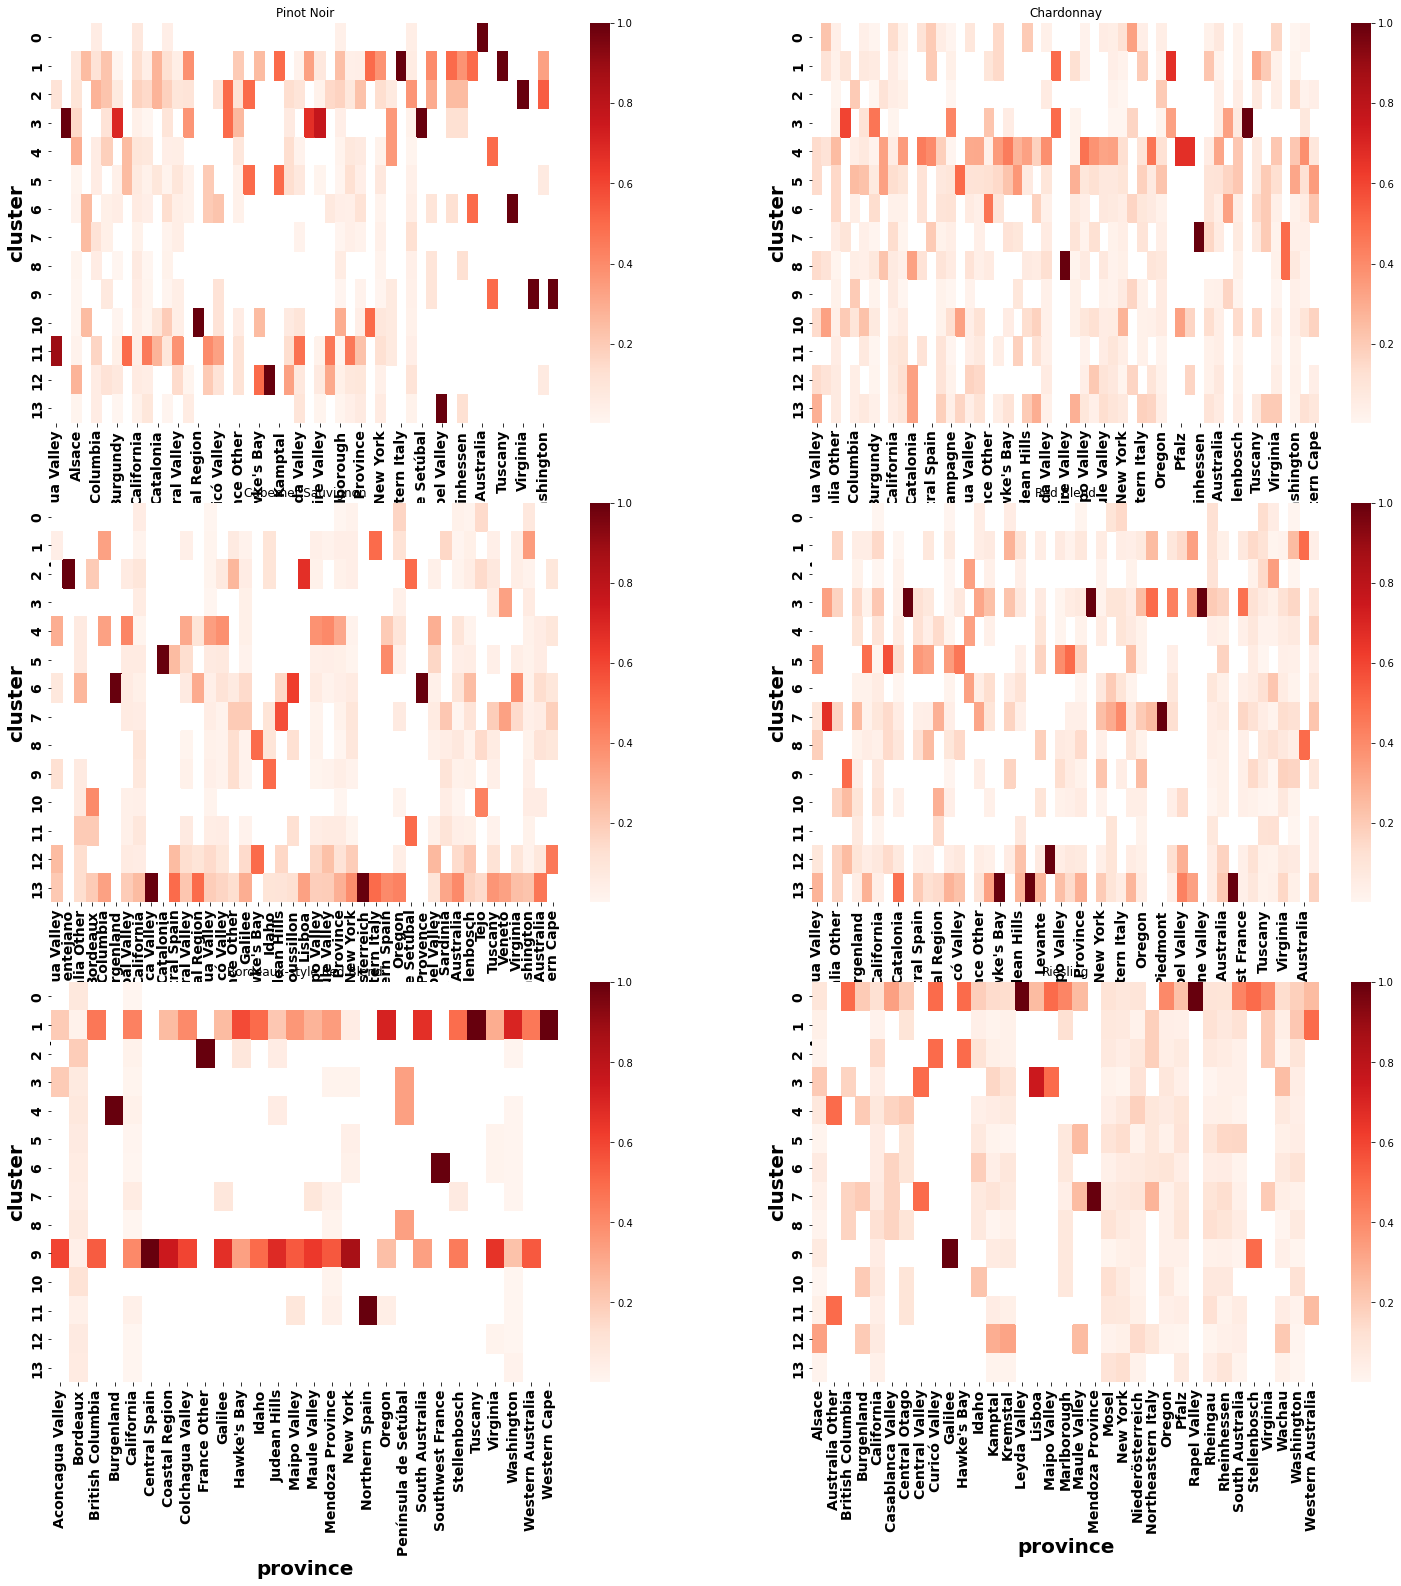

In [ ]:
def plot_kmeans(ax, variety):
  clusters_norm = varieties[variety].groupby(['cluster', REGION_COL]).size().unstack(level=REGION_COL)
  for col in clusters_norm:
    clusters_norm[col] = clusters_norm[col] / clusters_norm[col].sum()  # normalize each column on total instances in that column
  sns.heatmap(clusters_norm, ax=ax, cmap='Reds')
  ax.set_xlabel(REGION_COL, fontdict = {'weight': 'bold', 'size': 20})
  ax.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 20})
  ax.set_title(variety)
  for label in ax.get_xticklabels():
      label.set_size(14)
      label.set_weight("bold")
  for label in ax.get_yticklabels():
      label.set_size(14)
      label.set_weight("bold")
main_fig, axes = plt.subplots(3, 2, figsize=(25, 25))
ax_range = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]
for i in range(len(varieties)):
  plot_kmeans(axes[ax_range[i]], top_varieties[i])
